In [19]:
# imports
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte
from skimage.io import imread,imsave
import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
from skimage.segmentation import flood, flood_fill
from skimage.morphology import binary_dilation,binary_erosion
%matplotlib inline

shape  (216, 700)


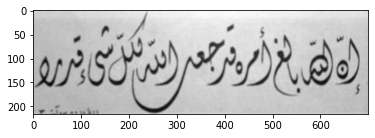

In [20]:
# read imahe and convert to Grey scale
img = imread("./ACDB/ACdata_base/1/0001.jpg", as_gray=True)
img = img.astype(np.float64) / np.max(img)
img = 255 * img
img = img.astype(np.uint8)
plt.imshow(img,cmap='gray')
print("shape ",img.shape)

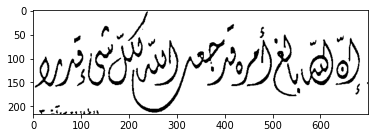

In [21]:
# binarization => this is the who;e text image 
t = sk.filters.threshold_local(img, 21, offset=10)
img = img > t
plt.imshow(img,cmap='gray')

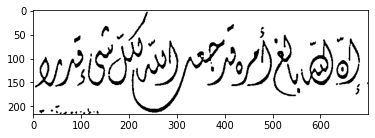

In [22]:
# remove noise 
img = binary_dilation(img)
img = binary_erosion(img)
plt.imshow(img,cmap="gray")

In [23]:
def show_images(images, titles=None):
    # This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

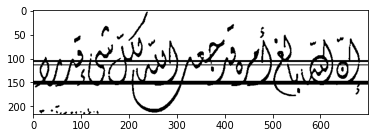

In [24]:
# make line to connect most large histograms 
horizontal_hist = np.sum(img,axis=1)
img_with_connection = np.copy(img)
max_hist = np.min(horizontal_hist)
tolerance = (10/100)*max_hist 
for i in range(img.shape[0]):
    if np.abs(horizontal_hist[i]-max_hist) <= tolerance:
        img_with_connection[i,:] = False 
plt.imshow(img_with_connection,cmap='gray')

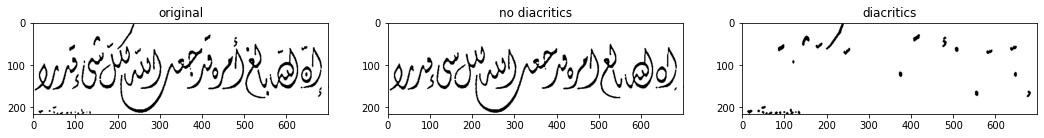

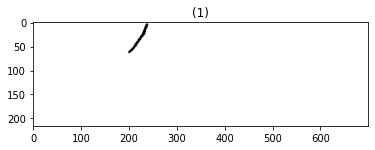

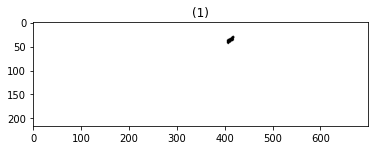

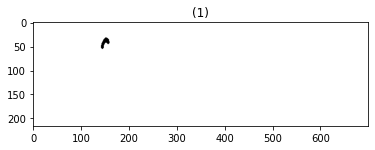

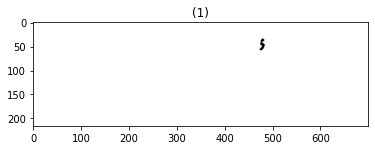

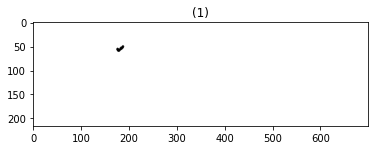

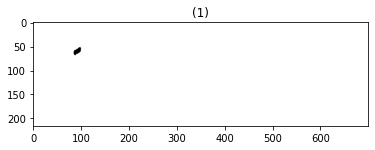

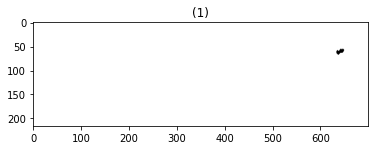

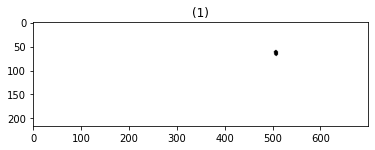

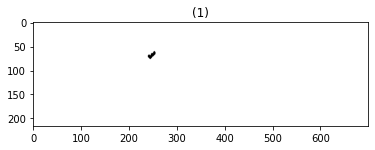

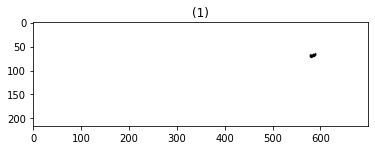

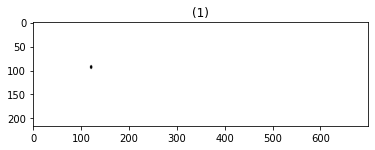

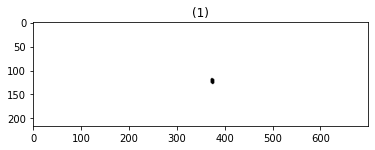

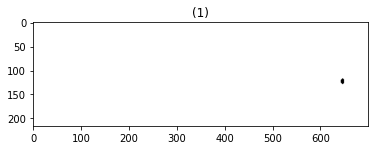

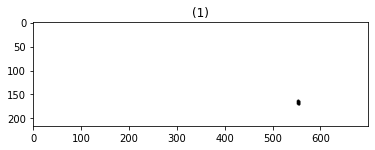

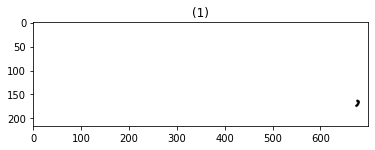

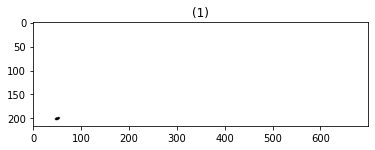

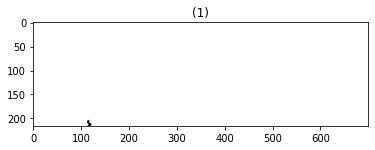

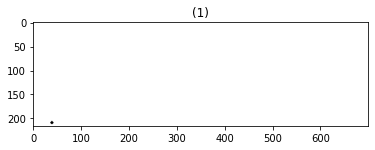

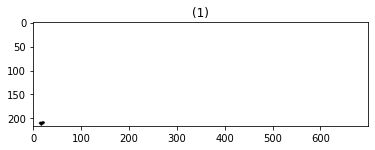

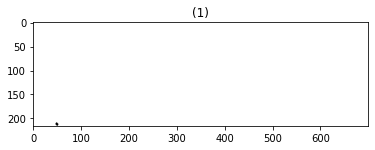

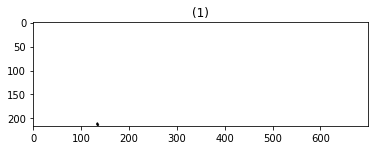

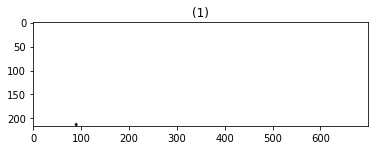

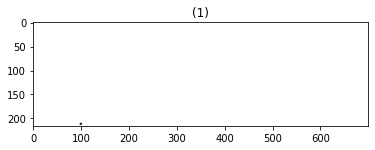

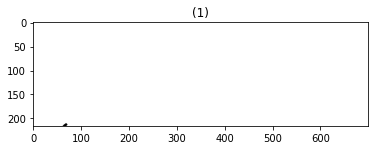

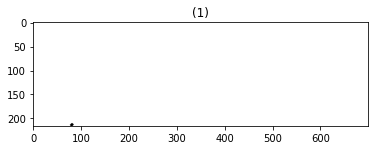

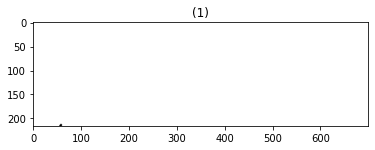

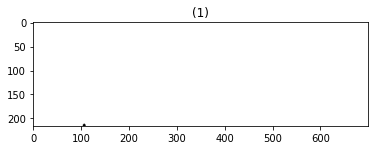

In [58]:
# get text only using flood fill algorithm 
# main observation 
# diacritics are way smaller than any charachter in the arabic text 
# thus set a threshold on number of pixels normalized if above the threshold then text else diacritics

def bfs(i,j,vis,img,img_copy,img_org):
    x = 1
    q = []
    q.append([i,j])
    vis[i][j] = True
    while len(q) != 0:
        i,j = q.pop(0)
        x += 1
        img_copy[i][j] = img_org[i][j]
        if img_copy[i][j] != img_org[i][j]:
            print("hi",img_copy[i][j] , img_org[i][j])
        di = [0,0,1,-1,1,-1,1,-1]
        dj = [-1,1,0,0,1,-1,-1,1]
        for k in range(8):
            ni = di[k] + i
            nj = dj[k] + j
            if ni>=0 and ni<img.shape[0] and nj>=0 and nj<img.shape[1] and vis[ni][nj]==0 and img[ni][nj] == False:
                vis[ni][nj] = True
                q.append([ni,nj])
    return x
# steps 
# 1- get darek pixels in image 
dark_pixels = img[img == False] 
# mark a vis array to check if pixel already vis or not
vis = np.zeros(img.shape)
img_int = img.astype(int)
imgs =[ ]
thresh = 4/100
total_text_pixels = img.shape[0]*img.shape[1] - np.sum(img)
max_img = np.copy(img)
max_num = 0
# loop on pixels and if dark && !vis then apply flood fill on it 
for i in range(img_int.shape[0]):
    for j in range(img_int.shape[1]):
        if vis[i][j] == 0 and img_with_connection[i][j] == False:
            img_copy = np.copy(img)
            img_copy[:] = True
            size_comp = bfs(i,j,vis,img_with_connection,img_copy,img)
            if size_comp > max_num:
                max_num = size_comp
                max_img = np.copy(img_copy)

img_diacritics = np.copy(img)
img_diacritics =  ~(img^max_img)
# get diacritics 
img_diacritics = binary_dilation(img_diacritics)
img_diacritics = binary_erosion(img_diacritics)
img_diacritics = binary_erosion(img_diacritics)
show_images([img,max_img,img_diacritics],["original","no diacritics","diacritics"])
vis = np.zeros(img.shape)
imgs =[ ]
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if vis[i][j] == 0 and img_diacritics[i][j] == False:
            img_copy = np.copy(img)
            img_copy[:] = True
            size_comp = bfs(i,j,vis,img_diacritics,img_copy,img_diacritics)
            ratio = size_comp/(img.shape[0]*img.shape[1])
            if ratio > 1/10000:
                imgs.append(img_copy)
for i in imgs:
    show_images([i])
